# Zillow Clustering Project

#### Robert Murphy

#### June 22 2021
_________________________________

------------------------------------

# Imports:

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy import stats

from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import viz_kmeans

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
# supress scientific notation
np.set_printoptions(suppress=True)

from sklearn.cluster import KMeans
import acquire
import explore
import zillow_wrangle
import prepare

In [2]:
# using a function which contains a implmentied sql query to bring in th dataset.
zillow_df = acquire.get_zillow_cached()
zillow_df= zillow_df.loc[:, ~zillow_df.columns.duplicated()]

zillow_df.head(1)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,propertylandusedesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc
0,1727539,14297519,nan,nan,nan,3.50,4.00,None,nan,3.50,...,"60,590,630,072,012.00",0.03,2017-01-01,Single Family Residential,None,None,None,None,None,None


In [3]:
zillow_df.set_index('parcelid', inplace = True)

In [4]:
# 52,968 records x 67 fields
zillow_df.shape

(52953, 67)

In [5]:
zillow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,"52,953.00","1,497,097.55","859,452.25",349.00,"757,502.00","1,500,314.00","2,241,055.00","2,982,270.00"
airconditioningtypeid,"13,650.00",2.44,3.84,1.00,1.00,1.00,1.00,13.00
architecturalstyletypeid,70.00,7.10,2.67,2.00,7.00,7.00,7.00,21.00
basementsqft,50.00,679.72,689.70,38.00,273.00,515.00,796.50,"3,560.00"
bathroomcnt,"52,953.00",2.29,1.02,0.00,2.00,2.00,3.00,18.00
bedroomcnt,"52,953.00",3.29,0.96,0.00,3.00,3.00,4.00,14.00
buildingqualitytypeid,"33,807.00",6.27,1.72,1.00,5.00,6.00,8.00,12.00
calculatedbathnbr,"52,748.00",2.30,1.02,1.00,2.00,2.00,3.00,18.00
decktypeid,415.00,66.00,0.00,66.00,66.00,66.00,66.00,66.00
finishedfloor1squarefeet,"4,724.00","1,508.89",670.26,66.00,"1,112.00","1,383.00","1,718.00","6,912.00"


In [6]:
# looking into duplicates and missing values
# right away there is several columns which contain a high number of missing values.
#  
prepare.miss_dup_values(zillow_df)

Your selected dataframe has 67 columns.
There are 52 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
buildingclasstypeid,52953,100.00
buildingclassdesc,52953,100.00
finishedsquarefeet15,52953,100.00
finishedsquarefeet13,52911,99.90
basementsqft,52903,99.90
storydesc,52903,99.90
storytypeid,52903,99.90
yardbuildingsqft26,52888,99.90
architecturalstyletypeid,52883,99.90
architecturalstyledesc,52883,99.90


In [7]:
prepare.summarize(zillow_df)

Dataframe head: 
               id  airconditioningtypeid  architecturalstyletypeid  \
parcelid                                                             
14297519  1727539                    nan                       nan   
17052889  1387261                    nan                       nan   
14186244    11677                    nan                       nan   
12177905  2288172                    nan                       nan   
12095076   781532                   1.00                       nan   
12069064   870991                    nan                       nan   
12790562  1246926                    nan                       nan   
11104527  1639362                   1.00                       nan   
13944538   249412                  13.00                       nan   
17110996    43675                    nan                       nan   

                 basementsqft          bathroomcnt           bedroomcnt  \
parcelid                                                           

---------------------

### Main Takeaways:

- Utilized a function which contains sql query to bring in dataset.
- Right away can see several columns which are missing several values over 50%. It might be ideal to just drop these columns.
- Will probably just keep columns which contain 90% non null values.
- Three datatypes; integer, float and object. 
- Some of the fields can be changed to a categorical utilizing 0 and 1.

--------------


# Prepare:

In [8]:
### No need to drop duplicates since there currently is none.###

In [9]:
# utilizing function which drops columns and rows that do not contain <90% non null values.
# this resulted in the shape ofd the df being 52801 records x 28 fields
zillow_check = prepare.handle_missing_values(zillow_df)
zillow_df = prepare.handle_missing_values(zillow_df)
zillow_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52801 entries, 14297519 to 12826780
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52801 non-null  int64  
 1   bathroomcnt                   52801 non-null  float64
 2   bedroomcnt                    52801 non-null  float64
 3   calculatedbathnbr             52731 non-null  float64
 4   calculatedfinishedsquarefeet  52794 non-null  float64
 5   finishedsquarefeet12          52597 non-null  float64
 6   fips                          52801 non-null  float64
 7   fullbathcnt                   52731 non-null  float64
 8   latitude                      52801 non-null  float64
 9   longitude                     52801 non-null  float64
 10  lotsizesquarefeet             52423 non-null  float64
 11  propertycountylandusecode     52801 non-null  object 
 12  propertylandusetypeid         52801 non-null  floa

In [10]:
#dropping nan values
zillow_df.dropna(inplace = True )

In [11]:
# shape of dataframe is now 51059 records, 28 fields
zillow_df.shape

(51059, 28)

In [12]:
#To Do:
#Drops: propertylandusedesc,censustractandblock, assessmentyear,id, regionidcity
#Renames:  finishedsquarefeet12 rename to finished living area. Change fips to the county names. 
# Create columns for age of the house and drop year built.

In [13]:
zillow_df = prepare.remove_columns(zillow_df,['propertylandusedesc','censustractandblock','propertycountylandusecode', 'rawcensustractandblock', 'assessmentyear','id', 'regionidcity', 'roomcnt','propertylandusetypeid','calculatedbathnbr'])

In [14]:
zillow_df.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'regionidcounty', 'regionidzip', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror', 'transactiondate'],
      dtype='object')

In [15]:
# renaming two columns
zillow_df.rename(columns = {'finishedsquarefeet12':'finished_living_area', 'calculatedfinishedsquarefeet':'total_square_ft'}, inplace = True)

def get_counties(df):
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    df_dummies = df_dummies.drop(columns = ['regionidcounty'])
    return df_dummies

get_counties(zillow_df)

In [16]:
zillow_df.head(1).T

parcelid,14297519
bathroomcnt,3.50
bedroomcnt,4.00
total_square_ft,"3,100.00"
finished_living_area,"3,100.00"
fips,"6,059.00"
fullbathcnt,3.00
latitude,"33,634,931.00"
longitude,"-117,869,207.00"
lotsizesquarefeet,"4,506.00"
regionidcounty,"1,286.00"


In [17]:
# change fips to counties, create new columns for age (2017-yearbuilt), can change sqft to acerage

# create taxrate variable
zillow_df['taxrate'] = zillow_df.taxamount/zillow_df.taxvaluedollarcnt*100
# create acreage variable
zillow_df['acres'] = zillow_df.lotsizesquarefeet/43560
zillow_df['structure_dollar_per_sqft'] = zillow_df.structuretaxvaluedollarcnt/zillow_df.total_square_ft
zillow_df['land_dollar_per_sqft'] = zillow_df.landtaxvaluedollarcnt/zillow_df.lotsizesquarefeet
zillow_df['county_name'] = zillow_df['fips'].map({6037:'Los_Angeles', 6059:'Orange', 6111:'Ventura'})
zillow_df['house_age'] = (2017-zillow_df.yearbuilt)

                               
                               


In [18]:
zillow_df.head()

,bathroomcnt,bedroomcnt,total_square_ft,finished_living_area,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,regionidcounty,...,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,county_name,house_age
parcelid,,,,,,,,,,,,,,,,,,,,,
14297519,3.50,4.00,"3,100.00","3,100.00","6,059.00",3.00,"33,634,931.00","-117,869,207.00","4,506.00","1,286.00",...,"537,569.00","11,013.72",0.03,2017-01-01,1.08,0.10,156.68,119.30,Orange,19.00
17052889,1.00,2.00,"1,465.00","1,465.00","6,111.00",1.00,"34,449,266.00","-119,281,531.00","12,647.00","2,061.00",...,"376,000.00","5,672.48",0.06,2017-01-01,1.22,0.29,60.07,29.73,Ventura,50.00
14186244,2.00,3.00,"1,243.00","1,243.00","6,059.00",2.00,"33,886,168.00","-117,823,170.00","8,432.00","1,286.00",...,"479,489.00","6,488.30",0.01,2017-01-01,1.15,0.19,68.62,56.87,Orange,55.00
12177905,3.00,4.00,"2,376.00","2,376.00","6,037.00",3.00,"34,245,180.00","-118,240,722.00","13,038.00","3,101.00",...,"36,225.00","1,777.51",-0.10,2017-01-01,1.22,0.30,45.84,2.78,Los_Angeles,47.00
12095076,3.00,4.00,"2,962.00","2,962.00","6,037.00",3.00,"34,145,202.00","-118,179,824.00","63,000.00","3,101.00",...,"496,619.00","9,516.26",-0.00,2017-01-01,1.23,1.45,93.41,7.88,Los_Angeles,67.00


In [19]:
#dropping columns
zillow_df.drop(columns = ['regionidzip', 'fips', 'fullbathcnt','transactiondate','regionidcounty','yearbuilt', 'regionidzip','finished_living_area','taxvaluedollarcnt'], inplace = True)

In [20]:
# now to change data types so as to exclude cents and additional inches included within float values.
cols = ['total_square_ft',
        'lotsizesquarefeet',
       'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt','structure_dollar_per_sqft','land_dollar_per_sqft']

In [21]:
#conversion function
def df_columns_to_datatype(df, column_list, dtype):
    df[column_list] = df[column_list].astype(dtype)

In [22]:
#dataframe shape after drops
zillow_df.shape

(51059, 16)

In [23]:
zillow_df['acres_bin'] = pd.cut(zillow_df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])
zillow_df['sqft_bin'] = pd.cut(zillow_df.total_square_ft, bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000], labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

In [24]:
#changing specified cols to integers.
df_columns_to_datatype(zillow_df, cols, 'int')

In [25]:
train, validate, test = prepare.split_continuous(zillow_df)

train -> (28592, 18)
validate -> (12255, 18)
test -> (10212, 18)


### Main Takeaways:
- Removed Nan values and dropped columns with <90% non null values. Resulted in the shape of DF becoming 
- Created dummies on Los, ventura and orange county.
- Dropped 8 columns,  and created 5 additional features.
- Shape of DF 51059 records, 24 fields.
- Created train, validate, and test datasets.


------------------

# Explore:

In [26]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,"28,592.00",2.30,1.01,1.00,2.00,2.00,3.00,13.00
bedroomcnt,"28,592.00",3.30,0.93,0.00,3.00,3.00,4.00,11.00
total_square_ft,"28,592.00","1,918.77",985.46,360.00,"1,270.00","1,657.00","2,297.00","20,612.00"
latitude,"28,592.00","34,023,954.56","272,464.85","33,341,224.00","33,829,928.50","34,027,663.50","34,187,836.75","34,818,767.00"
longitude,"28,592.00","-118,200,192.59","360,574.94","-119,475,265.00","-118,401,451.75","-118,157,177.00","-117,931,682.25","-117,572,421.00"
lotsizesquarefeet,"28,592.00","11,607.20","98,083.74",236.00,"5,568.00","6,835.50","8,760.00","6,971,010.00"
structuretaxvaluedollarcnt,"28,592.00","194,446.08","250,857.73",148.00,"77,351.50","130,994.00","222,412.25","9,164,901.00"
landtaxvaluedollarcnt,"28,592.00","329,588.33","517,608.85",161.00,"74,123.00","215,341.00","406,553.25","18,274,500.00"
taxamount,"28,592.00","6,364.28","8,145.94",89.18,"2,640.78","4,581.14","7,272.33","276,797.83"
logerror,"28,592.00",0.02,0.17,-4.66,-0.03,0.01,0.04,3.39


In [27]:
cols = zillow_df.drop(columns = 'county_name')
cols = cols.columns

In [28]:
# Start with looking into Outliers:
prepare.show_outliers(zillow_df,1.5,cols)

For bathroomcnt the lower bound is 0.5 and  upper bound is 4.5
For bedroomcnt the lower bound is 1.5 and  upper bound is 5.5
For total_square_ft the lower bound is -255.0 and  upper bound is 3801.0
For latitude the lower bound is 33293925.25 and  upper bound is 34723255.25
For longitude the lower bound is -119106625.0 and  upper bound is -117228429.0
For lotsizesquarefeet the lower bound is 738.5 and  upper bound is 13534.5
For structuretaxvaluedollarcnt the lower bound is -138292.0 and  upper bound is 435784.0
For landtaxvaluedollarcnt the lower bound is -422244.5 and  upper bound is 901027.5
For taxamount the lower bound is -4277.367499999999 and  upper bound is 14130.2925
For logerror the lower bound is -0.12281774739992499 and  upper bound is 0.138800588533075
For taxrate the lower bound is 0.8607319887104761 and  upper bound is 1.666160711674887
For acres the lower bound is 0.01695362718089992 and  upper bound is 0.31070936639118457
For structure_dollar_per_sqft the lower bound is

## Unviariate Exploration:

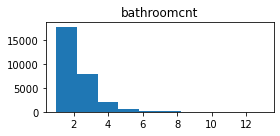

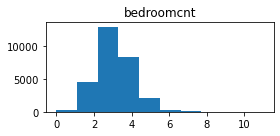

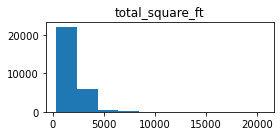

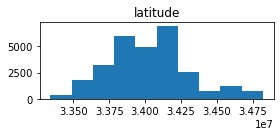

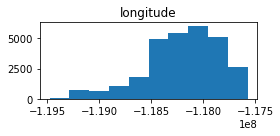

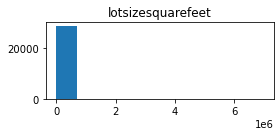

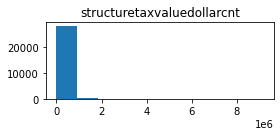

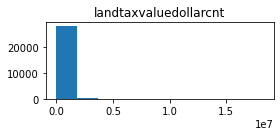

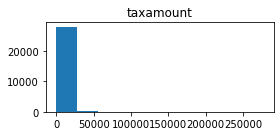

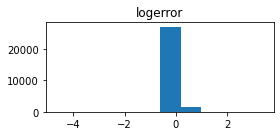

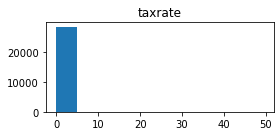

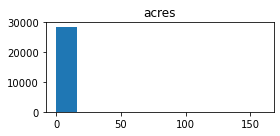

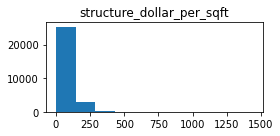

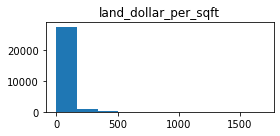

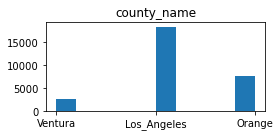

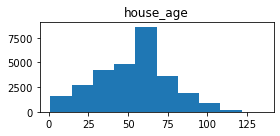

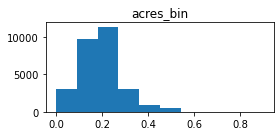

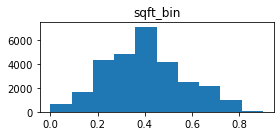

In [29]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.tight_layout()
    plt.show()

### Univariate chart takeaways:
- Normal Distribution: house_age, logitude, latitude, bedroomcnt
- Categoricals : county_name, bedroomcnt, bathroomcnt.


<AxesSubplot:title={'center':'Feautures  Correlating with logerror'}>

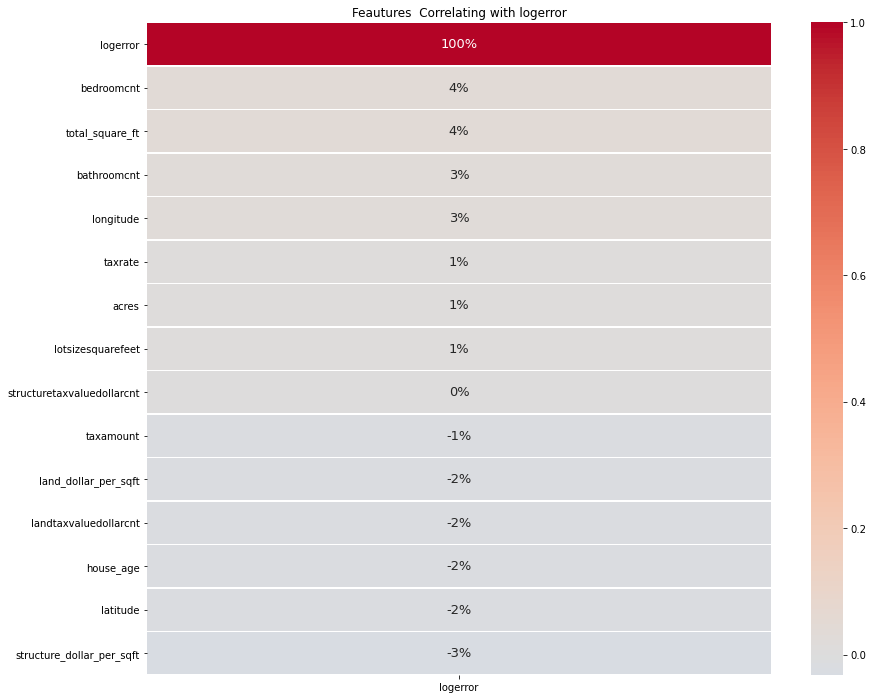

In [30]:
explore.get_heatmap(train,'logerror')

In [31]:
train.columns

Index(['bathroomcnt', 'bedroomcnt', 'total_square_ft', 'latitude', 'longitude',
       'lotsizesquarefeet', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror', 'taxrate', 'acres',
       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'county_name',
       'house_age', 'acres_bin', 'sqft_bin'],
      dtype='object')

In [32]:
train.drop(columns = ['bathroomcnt','lotsizesquarefeet',
       'landtaxvaluedollarcnt', 'taxamount'], inplace = True)

In [33]:
validate.drop(columns = ['bathroomcnt','lotsizesquarefeet',
       'landtaxvaluedollarcnt', 'taxamount'], inplace = True)

In [34]:
test.drop(columns = ['bathroomcnt','lotsizesquarefeet',
       'landtaxvaluedollarcnt', 'taxamount'], inplace = True)

### Heatmap Takeaways:
- correlations are not the strongest but there is still some.

In [35]:
train['logerror_bin'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])
train.head()

,bedroomcnt,total_square_ft,latitude,longitude,structuretaxvaluedollarcnt,logerror,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,county_name,house_age,acres_bin,sqft_bin,logerror_bin
parcelid,,,,,,,,,,,,,,,
17255924,4.00,1695,"34,264,216.00","-118,732,163.00",171500,-0.09,1.17,0.24,101,30,Ventura,56.00,0.20,0.40,"(-0.2, -0.05]"
12416186,3.00,1370,"33,866,570.00","-118,072,353.00",93772,-0.01,1.16,0.21,68,41,Los_Angeles,70.00,0.20,0.30,"(-0.05, 0.05]"
11005381,3.00,1564,"34,241,013.00","-118,272,231.00",77948,0.09,1.28,0.21,49,2,Los_Angeles,61.00,0.20,0.40,"(0.05, 0.2]"
11704478,4.00,2373,"33,998,435.00","-118,298,452.00",81699,-0.07,1.27,0.13,34,37,Los_Angeles,105.00,0.10,0.50,"(-0.2, -0.05]"
14102079,3.00,1332,"33,786,571.00","-117,905,985.00",68543,0.00,1.28,0.17,51,37,Orange,62.00,0.20,0.30,"(-0.05, 0.05]"


In [36]:
# creating pairplot

sns.pairplot(data = train, hue = 'logerror_bin')

## PairPlot Takeaways:

Every feature has a section which contains a large spread for error so I would assume moving forward that these features will be useful in clustering.  

In [37]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,"28,592.00",3.30,0.93,0.00,3.00,3.00,4.00,11.00
total_square_ft,"28,592.00","1,918.77",985.46,360.00,"1,270.00","1,657.00","2,297.00","20,612.00"
latitude,"28,592.00","34,023,954.56","272,464.85","33,341,224.00","33,829,928.50","34,027,663.50","34,187,836.75","34,818,767.00"
longitude,"28,592.00","-118,200,192.59","360,574.94","-119,475,265.00","-118,401,451.75","-118,157,177.00","-117,931,682.25","-117,572,421.00"
structuretaxvaluedollarcnt,"28,592.00","194,446.08","250,857.73",148.00,"77,351.50","130,994.00","222,412.25","9,164,901.00"
logerror,"28,592.00",0.02,0.17,-4.66,-0.03,0.01,0.04,3.39
taxrate,"28,592.00",1.33,0.62,0.01,1.16,1.23,1.36,49.36
acres,"28,592.00",0.27,2.25,0.01,0.13,0.16,0.20,160.03
structure_dollar_per_sqft,"28,592.00",89.84,59.31,0.00,54.00,81.00,113.00,"1,444.00"
land_dollar_per_sqft,"28,592.00",47.94,72.60,0.00,9.00,30.00,60.00,"1,693.00"


----------

# Statistical Testing:

 Pearson correlation coefficient is -0.018476186938612242, the corresponding p value is 0.0017822877823141347.
 We reject the null, and accept HA, There is a relationship between logerror and house_age.


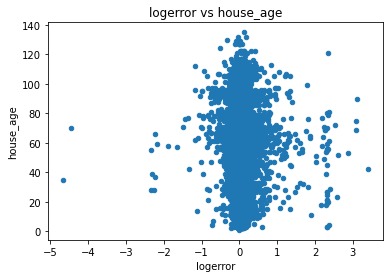

In [38]:
#Pearson Correlation

Null = 'There is no relationship between logerror and house_age'
HA = 'There is a relationship between logerror and house_age'
   
alpha = 0.05

corr, p = stats.pearsonr(train.house_age, train.logerror)
print(f' Pearson correlation coefficient is {corr}, the corresponding p value is {p}.')


train.plot.scatter('logerror', 'house_age')
plt.title('logerror vs house_age')

if p < 0.05:
    print(f' We reject the null, and accept HA, {HA}.')
else:
    print(f' We accept null, {Null}.')

 Pearson correlation coefficient is 0.03509652092591808, the corresponding p value is 2.9188313776264663e-09.
 We reject the null, and accept HA, There is a relationship between logerror and total_square_ft.


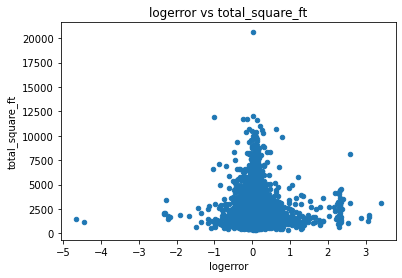

In [39]:
#Pearson Correlation

Null = 'There is no relationship between logerror and total_square_ft'
HA = 'There is a relationship between logerror and total_square_ft'
   
alpha = 0.05

corr, p = stats.pearsonr(train.total_square_ft, train.logerror)
print(f' Pearson correlation coefficient is {corr}, the corresponding p value is {p}.')


train.plot.scatter('logerror', 'total_square_ft')
plt.title('logerror vs total_square_ft')

if p < 0.05:
    print(f' We reject the null, and accept HA, {HA}.')
else:
    print(f' We accept null, {Null}.')

 Pearson correlation coefficient is -0.019544544352255805, the corresponding p value is 0.0009497937347813823.
 We reject the null, and accept HA, There is a relationship between logerror and latitude.


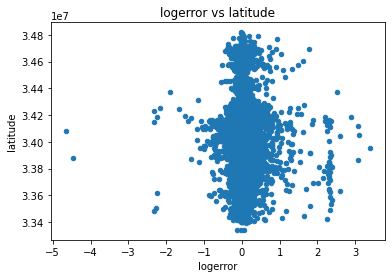

In [40]:
#Pearson Correlation

Null = 'There is no relationship between logerror and latitude'
HA = 'There is a relationship between logerror and latitude'
   
alpha = 0.05

corr, p = stats.pearsonr(train.latitude, train.logerror)
print(f' Pearson correlation coefficient is {corr}, the corresponding p value is {p}.')


train.plot.scatter('logerror', 'latitude')
plt.title('logerror vs latitude')

if p < 0.05:
    print(f' We reject the null, and accept HA, {HA}.')
else:
    print(f' We accept null, {Null}.')

In [41]:
#levene HO: equal variance across logerror between bedroomcount less than 3 and greater than 3.
stats.levene(train[train.bedroomcnt <= 3].logerror, train[train.bedroomcnt > 3].logerror)

LeveneResult(statistic=4.782395343756247, pvalue=0.028760174628959172)

In [42]:
#TTest 
# make a subset 
x1 = train[train.bedroomcnt <= 3].logerror
x2 = train[train.bedroomcnt > 3].logerror


# run a 2 sample, 2 tail t-test
t_stat, p = stats.ttest_ind(x1, x2)

print(f'\nstatistic = {t_stat:.4f}')
print(f'p_value = {p:.4f}')

# set alpha
alpha = 0.05

null_hypothesis = "There is no significant difference in the logerrors for those who have four or more bedrooms than those who dont."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')


statistic = -5.3629
p_value = 0.0000

We can reject the null hypothesis that There is no significant difference in the logerrors for those who have four or more bedrooms than those who dont.


In [43]:
#levene HO: equal variance across logerror between total_square_ft <=2500 and greater than 2500.
stats.levene(train[train.total_square_ft <= 2500].logerror, train[train.total_square_ft > 2500].logerror)

LeveneResult(statistic=22.83212490062288, pvalue=1.7766291037147606e-06)

In [44]:
#TTest 
# make a subset 
x1 = train[train.total_square_ft <= 2500].logerror
x2 = train[train.total_square_ft > 2500].logerror


# run a 2 sample, 2 tail t-test
t_stat, p = stats.ttest_ind(x1, x2)

print(f'\nstatistic = {t_stat:.4f}')
print(f'p_value = {p:.4f}')

# set alpha
alpha = 0.05

null_hypothesis = "There is no significant difference in the logerrors for homes with less than 2500 sqrft than homes with greater than."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')


statistic = -6.3909
p_value = 0.0000

We can reject the null hypothesis that There is no significant difference in the logerrors for homes with less than 2500 sqrft than homes with greater than.


In [45]:
#levene HO: equal variance across logerror between total_square_ft <=2500 and greater than 2500.
stats.levene(train[train.house_age <= 60].logerror, train[train.house_age > 60].logerror)

LeveneResult(statistic=163.60494281610625, pvalue=2.3364853853631596e-37)

In [46]:
#TTest 
# make a subset 
x1 = train[train.house_age <= 60].logerror
x2 = train[train.house_age > 60].logerror


# run a 2 sample, 2 tail t-test
t_stat, p = stats.ttest_ind(x1, x2)

print(f'\nstatistic = {t_stat:.4f}')
print(f'p_value = {p:.4f}')

# set alpha
alpha = 0.05

null_hypothesis = "There is no significant difference in the logerrors for homes greater than 60 years old than homes less than 60 years old"

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')


statistic = 3.4934
p_value = 0.0005

We can reject the null hypothesis that There is no significant difference in the logerrors for homes greater than 60 years old than homes less than 60 years old


----------

-----------------

# Exploration: Clustering

In [47]:
# this will be done on unscaled data!

### Work on unscaled!

In [55]:
from sklearn.preprocessing import StandardScaler

In [56]:
X = train[['latitude', 'longitude']]

In [57]:
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

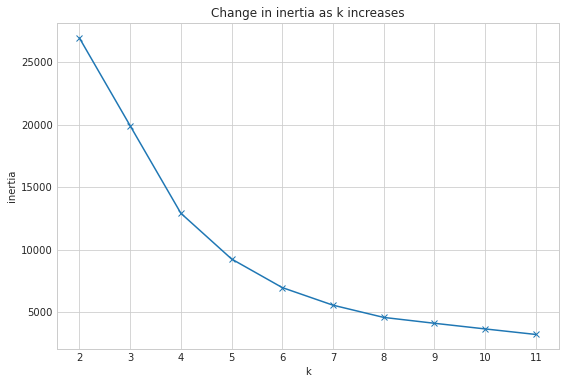

In [58]:
# use elbow method
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    #drop of at 3

In [61]:
#Utilize the kmeans
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X_scaled)
X_scaled['cluster'] = kmeans.predict(X_scaled)

In [62]:
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=X_scaled.columns)
centroids_scaled

,latitude,longitude,cluster
0,-0.11,0.12,1.00
1,-1.18,1.05,0.00
2,0.76,-1.38,2.00
3,2.20,0.19,3.00


Text(0.5, 1.0, 'Visualizing Cluster Centers')

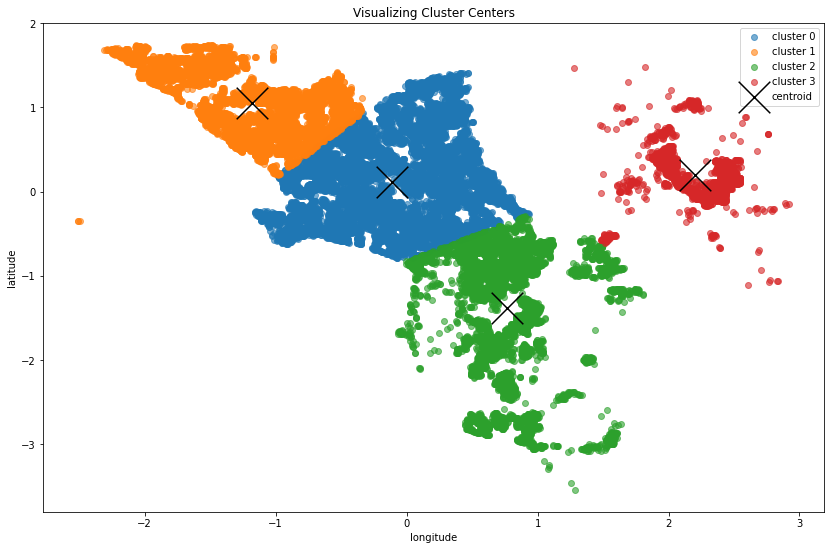

In [63]:
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('cluster'):
    plt.scatter(subset.latitude, subset.longitude, label='cluster ' + str(cluster), alpha=.6)

centroids_scaled.plot.scatter(x='latitude', y='longitude', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Visualizing Cluster Centers')

-----------

---------

In [64]:
X = train[['longitude', 'house_age']]

In [65]:
scaler = StandardScaler().fit(X)
X1_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

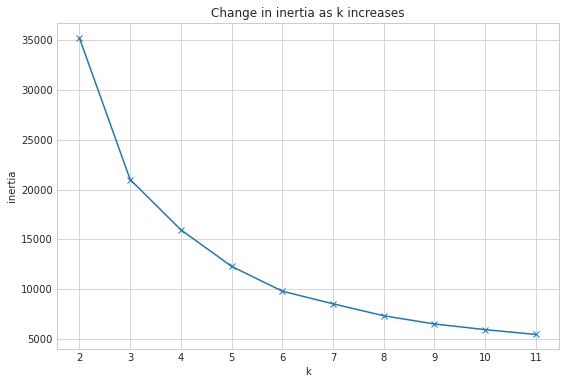

In [66]:
# use elbow method
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X1_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    #drop of at 3

In [69]:
#Utilize the kmeans
kmeans = KMeans(n_clusters =3)
kmeans.fit(X1_scaled)
X1_scaled['cluster'] = kmeans.predict(X1_scaled)

In [70]:
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=X1_scaled.columns)
centroids_scaled

,longitude,house_age,cluster
0,-0.04,0.77,-0.00
1,0.86,-0.82,1.00
2,-1.59,-0.63,2.00


Text(0.5, 1.0, 'Visualizing Cluster Centers')

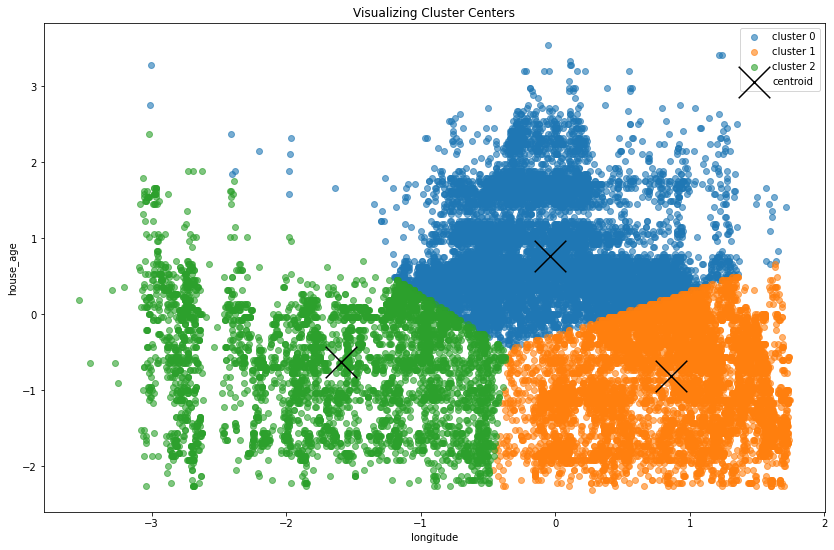

In [71]:
plt.figure(figsize=(14, 9))

for cluster, subset in X1_scaled.groupby('cluster'):
    plt.scatter(subset.longitude, subset.house_age, label='cluster ' + str(cluster), alpha=.6)

centroids_scaled.plot.scatter(x='longitude', y='house_age', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('longitude')
plt.ylabel('house_age')
plt.title('Visualizing Cluster Centers')

-------------

-----------

In [72]:
#start w/ 2 features
X = train[['acres', 'house_age']]
X.head()

,acres,house_age
parcelid,,
17255924,0.24,56.00
12416186,0.21,70.00
11005381,0.21,61.00
11704478,0.13,105.00
14102079,0.17,62.00


In [73]:
scaler = StandardScaler().fit(X)
X3_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [74]:
X3_scaled.acres.max()

70.95492810631082

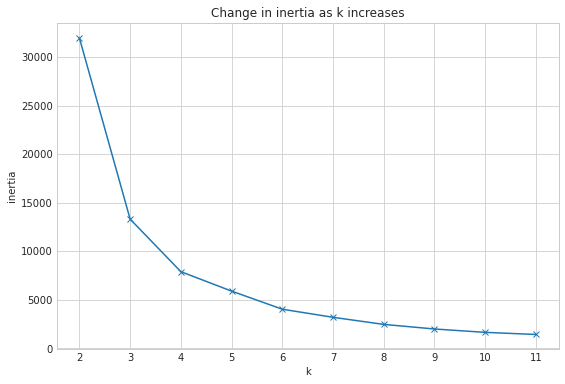

In [75]:
# use elbow method
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    #drop of at 4

In [77]:
kmeans = KMeans(n_clusters =4)
kmeans.fit(X3_scaled)
X3_scaled['cluster'] = kmeans.predict(X3_scaled)

In [78]:
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=X3_scaled.columns)
centroids_scaled

,acres,house_age,cluster
0,-0.02,1.52,3.00
1,-0.03,0.22,0.00
2,0.02,-1.21,2.00
3,70.95,-1.33,1.00


Text(0.5, 1.0, 'Visualizing Cluster Centers')

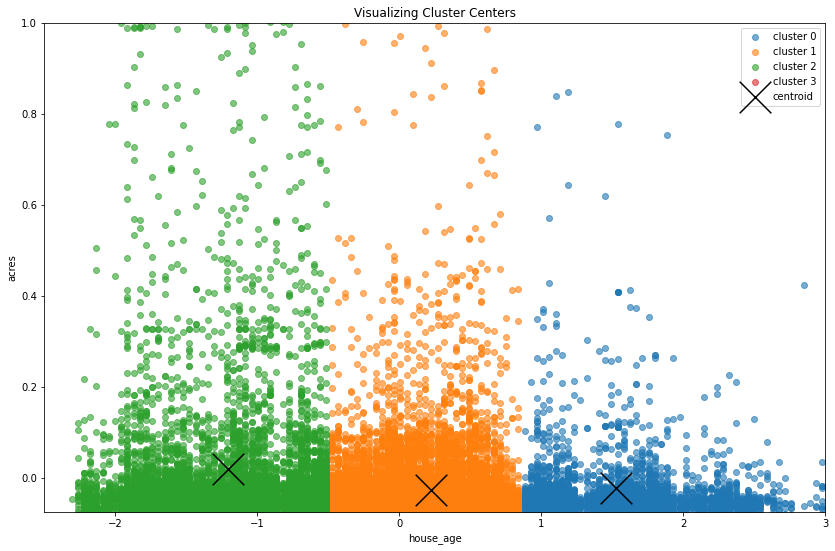

In [79]:
plt.figure(figsize=(14, 9))

for cluster, subset in X3_scaled.groupby('cluster'):
    plt.scatter(subset.house_age, subset.acres, label='cluster ' + str(cluster), alpha=.6)
    plt.ylim(top = 1, bottom = -0.075)
    plt.xlim(left = -2.5, right = 3)

centroids_scaled.plot.scatter(x='house_age', y='acres', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('house_age')
plt.ylabel('acres')
plt.title('Visualizing Cluster Centers')

In [80]:
X = train[['structuretaxvaluedollarcnt', 'house_age']]

In [81]:
scaler = StandardScaler().fit(X)
X4_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

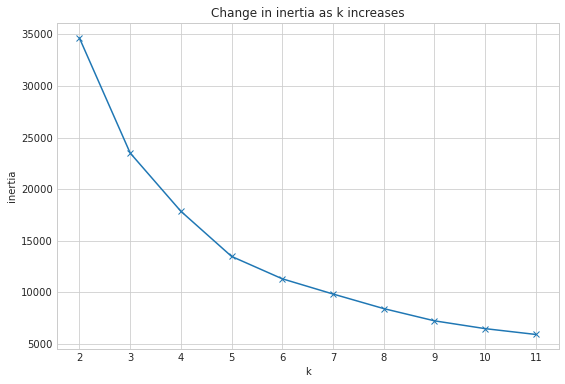

In [82]:
# use elbow method
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X4_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    

In [85]:
kmeans = KMeans(n_clusters =5)
kmeans.fit(X4_scaled)
X4_scaled['cluster'] = kmeans.predict(X4_scaled)

In [86]:
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=X4_scaled.columns)
centroids_scaled

,structuretaxvaluedollarcnt,house_age,cluster
0,-0.30,0.23,1.00
1,-0.27,1.54,4.00
2,0.21,-1.15,-0.00
3,10.63,-1.06,3.00
4,2.68,-1.10,2.00


Text(0.5, 1.0, 'Visualizing Cluster Centers')

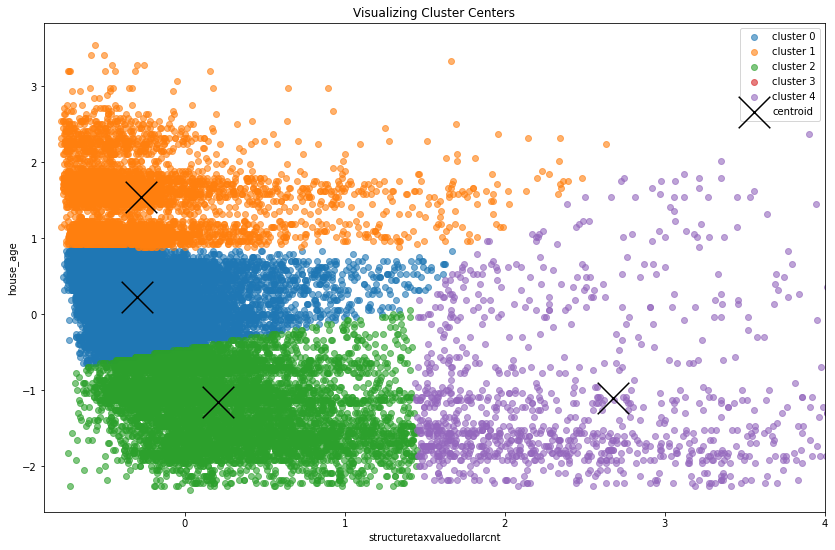

In [87]:
plt.figure(figsize=(14, 9))

for cluster, subset in X4_scaled.groupby('cluster'):
    plt.scatter(subset.structuretaxvaluedollarcnt, subset.house_age, label='cluster ' + str(cluster), alpha=.6)
    plt.xlim(right = 4)
centroids_scaled.plot.scatter(x='structuretaxvaluedollarcnt', y='house_age', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('structuretaxvaluedollarcnt')
plt.ylabel('house_age')
plt.title('Visualizing Cluster Centers')

In [ ]:
train.head(2).T

# Modeling:

used scaled features within modeling.

#### features to use:
house_age, total_square_ft, bedroomcnt, logerror, longitude, latitude, structuretaxvaluedollarcnt


In [ ]:
numeric_cols = ['house_age', 'total_square_ft', 'bedroomcnt', 'logerror', 'longitude', 'latitude', 'structuretaxvaluedollarcnt', 'logerror']
cols = ['house_age', 'total_square_ft', 'bedroomcnt', 'longitude', 'latitude', 'structuretaxvaluedollarcnt', 'logerror']
target = ['logerror']

In [ ]:
X_train, y_train = train[cols], train[target]
X_validate, y_validate = validate[cols], validate[target]
X_test, y_test = test[cols], test[target]

In [ ]:
X_train_scaled, X_validate_scaled, X_test_scaled = prepare.min_max_scale(X_train, X_validate, X_test, numeric_cols)

In [ ]:
cols = ['house_age', 'total_square_ft', 'bedroomcnt', 'longitude', 'latitude', 'structuretaxvaluedollarcnt']
target = ['logerror']

In [ ]:
X_train_scaled, y_train_scaled = X_train_scaled[cols], X_train_scaled[target]
X_validate_scaled, y_validate_scaled = X_validate_scaled[cols], X_validate_scaled[target]
X_test_scaled, y_test_scaled = X_test_scaled[cols], X_test_scaled[target]

In [54]:
def create_cluster(df, X, k, col_name = None):
    """ Takes in df, X (dataframe with variables you want to cluster on) and k
    # It scales the X, calcuates the clusters and return train (with clusters), the Scaled dataframe,
    #the scaler and kmeans object and scaled centroids as a dataframe"""
    scaler = StandardScaler(copy=True).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X_scaled)
    centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = list(X))
    if col_name == None:
        #clusters on dataframe 
        df[f'clusters_{k}'] = kmeans.predict(X_scaled)
    else:
        df[col_name] = kmeans.predict(X_scaled)
    return df, X_scaled, scaler, kmeans, centroids_scaled